In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __builtin__ import any as b_any

import math
import os
os.environ["CUDA_VISIBLE_DEVICES"]=""
import numpy as np
from PIL import Image

import tensorflow as tf

import configuration
import inference_wrapper
import sys
sys.path.insert(0, 'im2txt/inference_utils')
sys.path.insert(0, 'im2txt/ops')
import caption_generator
import image_processing
import vocabulary

In [2]:

current_dir = os.getcwd()
image_dir = os.path.join(current_dir, 'Jmemes')


checkpoint_path="trainlogIncNEW"
vocab_file ="vocab4.txt"
input_files ="Jmemes"         

tf.logging.set_verbosity(tf.logging.INFO)


In [3]:
#configuration
config = configuration.ModelConfig()

g = tf.Graph()
with g.as_default():
    model = inference_wrapper.InferenceWrapper()
    restore_fn = model.build_graph_from_config(config,
                                               checkpoint_path)
g.finalize()


INFO:tensorflow:Building model.
About to decide if splitting
new_h Tensor("lstm/basic_lstm_cell/Mul_2:0", shape=(1, 512), dtype=float32)
new_state LSTMStateTuple(c=<tf.Tensor 'lstm/basic_lstm_cell/Add_1:0' shape=(1, 512) dtype=float32>, h=<tf.Tensor 'lstm/basic_lstm_cell/Mul_2:0' shape=(1, 512) dtype=float32>)
About to decide if splitting
It's splitting
h Tensor("lstm/Squeeze_1:0", shape=(1, 2, 512), dtype=float32)
inputs Tensor("seq_embeddings:0", shape=(1, 2, 300), dtype=float32)
gate_inputs0 Tensor("lstm/basic_lstm_cell/einsum/Reshape_1:0", shape=(1, 1, 2048), dtype=float32)
gate_inputs1 Tensor("lstm/basic_lstm_cell/einsum_1/Reshape_1:0", shape=(1, 1, 2048), dtype=float32)
squeeze Tensor("lstm/basic_lstm_cell/Squeeze_2:0", shape=(812,), dtype=float32)
<tf.Variable 'lstm/basic_lstm_cell/kernel:0' shape=(812, 2048) dtype=float32_ref>
gate_inputs Tensor("lstm/basic_lstm_cell/concat_2:0", shape=(1, 2, 2048), dtype=float32)
new_h Tensor("lstm/basic_lstm_cell/Mul_5:0", shape=(1, 2, 512), 

In [4]:
vocab = vocabulary.Vocabulary(vocab_file)

with open('Captions.txt','r') as f:
    data_captions = f.readlines()
data_captions = [s.lower() for s in data_captions]
  
with open('ordered_memes.txt','r') as f:
    ordered_memes = f.readlines()
ordered_memes = [meme.replace('\n','') for meme in ordered_memes]

INFO:tensorflow:Initializing vocabulary from file: vocab4.txt
INFO:tensorflow:Created vocabulary with 38521 words


In [5]:
histo = []
filenames = [os.path.join(image_dir, f) for f in os.listdir(input_files) if f.endswith('.jpg') or f.endswith('.JPG')]
print(filenames)
tf.logging.info("Running caption generation on %d files matching %s",len(filenames), input_files)
with tf.Session(graph=g) as sess:
    # Load the model from checkpoint.
    restore_fn(sess)
    
    # Prepare the caption generator. Here we are implicitly using the default
    # beam search parameters. See caption_generator.py for a description of the
    # available beam search parameters.
    generator = caption_generator.CaptionGenerator(model, vocab, beam_size=config.beam_size)
    num_in_data_total = 0
    num_captions = 0
    for i,filename in enumerate(filenames):
      with tf.gfile.GFile(filename, "rb") as f:
        #image = f.read()
        image = Image.open(f)
        image = ((np.array(image.resize((299,299)))/255.0)-0.5)*2.0 
        
      print("Captions for image %s:" % os.path.basename(filenames[i]))
      num_in_data = 0
      for k in range(6):
          captions = generator.beam_search(sess, image)
            
          for i, caption in enumerate(captions):
            # Ignore begin and end words.
            histo.append(caption.sentence[1:-1])
            sentence = [vocab.id_to_word(w) for w in caption.sentence[1:-1]]
            sentence = " ".join(sentence)
            in_data = 0
            '''
            if b_any(sentence in capt for capt in data_captions):
                in_data = 1
                num_in_data += 1
                num_in_data_total += 1
                num_captions += 1
            else:
                num_captions += 1
            '''  
            
            print("  %d) %s (p=%f) [in data = %d]" % (i, sentence, math.exp(caption.logprob),in_data))
      print("number of captions in data = %d" % (num_in_data))
    print("(total number of captions in data = %d) percent in data = %f" % (num_in_data_total,(num_in_data_total/num_captions)))

['/Users/ALP/PycharmProjects/MemeProject/im2txt/Jmemes/non-binary-seahorse.jpg', '/Users/ALP/PycharmProjects/MemeProject/im2txt/Jmemes/sassy-gay-snape.jpg', '/Users/ALP/PycharmProjects/MemeProject/im2txt/Jmemes/niggas-be-like.jpg', '/Users/ALP/PycharmProjects/MemeProject/im2txt/Jmemes/NOSE.jpg', '/Users/ALP/PycharmProjects/MemeProject/im2txt/Jmemes/b06bdacc-3446-47c6-ab37-4297af427dc6.JPG', '/Users/ALP/PycharmProjects/MemeProject/im2txt/Jmemes/jplp.jpg', '/Users/ALP/PycharmProjects/MemeProject/im2txt/Jmemes/f67f1988-244a-4f8d-af8d-728ae07f5594.JPG', '/Users/ALP/PycharmProjects/MemeProject/im2txt/Jmemes/Swallow_flying_drinking.jpg', '/Users/ALP/PycharmProjects/MemeProject/im2txt/Jmemes/hipster-pocahontas.jpg', '/Users/ALP/PycharmProjects/MemeProject/im2txt/Jmemes/romneyhood.jpg', '/Users/ALP/PycharmProjects/MemeProject/im2txt/Jmemes/6412c66b-513f-42bb-833e-e96b53bc1831.JPG', '/Users/ALP/PycharmProjects/MemeProject/im2txt/Jmemes/obama-laughing.jpg', '/Users/ALP/PycharmProjects/MemeProjec

  0) is my favorite color ? (p=0.000000) [in data = 0]
  1) is my favorite animal ? my name (p=0.000000) [in data = 0]
  0) your the last day of school ! (p=0.000000) [in data = 0]
  1) your the last day of school ! ! ! (p=0.000000) [in data = 0]
  0) i like my eggs like potatoes (p=0.000000) [in data = 0]
  1) i like my eggs like i like it ! (p=0.000000) [in data = 0]
  0) says he hates me ! ! ! (p=0.000000) [in data = 0]
  1) says he hates me ! ! ! ! ! ! (p=0.000000) [in data = 0]
  0) does not have a good time bro (p=0.000000) [in data = 0]
  1) does not have a good time for an assignment to see what a kid is (p=0.000000) [in data = 0]
  0) why do you hate me ? ? (p=0.000000) [in data = 0]
  1) why do you hate me ? ? because i'm allergic to you (p=0.000000) [in data = 0]
number of captions in data = 0
Captions for image f67f1988-244a-4f8d-af8d-728ae07f5594.JPG:
  0) hey girl , i saw you checking me so i'm a stupid , and i know it , (p=0.000000) [in data = 0]
  1) hey girl , i saw yo

  0) i am not a fish (p=0.000000) [in data = 0]
  1) i am not a fish i just throw a potato (p=0.000000) [in data = 0]
  0) what you looking at me (p=0.000001) [in data = 0]
  1) what you looking at when i need to hang out with me (p=0.000000) [in data = 0]
  0) dude i'm a fat girl ! ! ! (p=0.000000) [in data = 0]
  1) dude i'm a fat girl ! ! ! ! ! ! ! ! (p=0.000000) [in data = 0]
  0) i have no idea what i think i am (p=0.000000) [in data = 0]
  1) i have no idea what i think i am . (p=0.000000) [in data = 0]
  0) what do you mean you didn't have to do the dishes ! (p=0.000000) [in data = 0]
  1) what do you mean you didn't have to do the homework today ? (p=0.000000) [in data = 0]
  0) i got a new phone but it was a virus (p=0.000000) [in data = 0]
  1) i got a new phone but it was a little inside (p=0.000000) [in data = 0]
number of captions in data = 0
Captions for image heartless-harry.jpg:
  0) i had a dream so i took a picture (p=0.000000) [in data = 0]
  1) i had a dream so i to

  0) my face is mine (p=0.000002) [in data = 0]
  1) my face when i get a bit of the ice cream cone (p=0.000000) [in data = 0]
  0) happy birthday sarah (p=0.000051) [in data = 0]
  1) i'm a fucking unicorn all i know (p=0.000000) [in data = 0]
number of captions in data = 0
Captions for image Random_Turtle.jpg:
  0) no one gives a shit (p=0.000006) [in data = 0]
  1) no one gives a fuck , i'll give you 5 bucks (p=0.000000) [in data = 0]
  0) hey there (p=0.000066) [in data = 0]
  1) hey there ! ! ! ! (p=0.000000) [in data = 0]
  0) this is how i shit (p=0.000000) [in data = 0]
  1) this is how i shit when i get in (p=0.000000) [in data = 0]
  0) you think i'm fat ? (p=0.000000) [in data = 0]
  1) you think i'm gonna do this job (p=0.000000) [in data = 0]
  0) i'm not racist i just think i'm a dog (p=0.000000) [in data = 0]
  1) i'm not racist i just think i'm white and white man (p=0.000000) [in data = 0]
  0) i had no idea what i wanted (p=0.000000) [in data = 0]
  1) i had no idea w

  0) the house is here (p=0.000000) [in data = 0]
  1) the house is looking at it (p=0.000000) [in data = 0]
  0) they said i could be anything so i became a meme ! (p=0.000000) [in data = 0]
  1) they said i could be anything so i became a meme right now (p=0.000000) [in data = 0]
  0) my name is steve . . . i love my brother ! (p=0.000000) [in data = 0]
  1) my name is steve . . . i love my brother like my brother ! ! ! (p=0.000000) [in data = 0]
  0) i gave the shit out of water (p=0.000000) [in data = 0]
  1) i gave the shit out of water because i was a cat (p=0.000000) [in data = 0]
  0) my face when the people say im a rapist (p=0.000000) [in data = 0]
  1) my face when the people say im a sexy ninja (p=0.000000) [in data = 0]
number of captions in data = 0
Captions for image 70e71770-42ce-4fd1-90ef-fc52b5903ab4.JPG:
  0) you call the guy who likes to me (p=0.000000) [in data = 0]
  1) you call the guy who likes you ? i would like to make a meme . (p=0.000000) [in data = 0]
  0) 

  0) fuck yeah ! (p=0.000075) [in data = 0]
  1) fuck yeah i want (p=0.000000) [in data = 0]
  0) hey alex , wanna play ? (p=0.000000) [in data = 0]
  1) hey alex , wanna play soccer ? (p=0.000000) [in data = 0]
  0) hey there i smell you (p=0.000000) [in data = 0]
  1) hey there i smell my weed (p=0.000000) [in data = 0]
  0) oppa gangnam style (p=0.008638) [in data = 0]
  1) oppa gangnam style ! (p=0.001090) [in data = 0]
number of captions in data = 0
Captions for image 296ec342-3e2c-4f01-a8bd-f5b6705d5118.JPG:
  0) this is a real life (p=0.000001) [in data = 0]
  1) this is a pretty face when you see a lot of time (p=0.000000) [in data = 0]
  0) i'm not saying that is my name (p=0.000000) [in data = 0]
  1) i'm not saying that is my mother (p=0.000000) [in data = 0]
  0) i don't always drink , but when i do , i make sure its on it (p=0.000000) [in data = 0]
  1) i don't always drink , but when i do , i make sure its on the internet (p=0.000000) [in data = 0]
  0) oh , so you want t

ZeroDivisionError: division by zero

In [8]:
flat_histo = [item for sublist in histo for item in sublist]

In [10]:
max(flat_histo)

38517

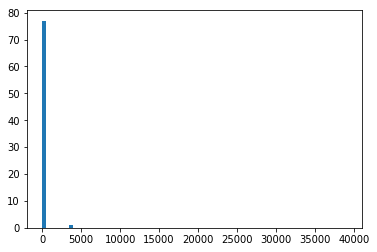

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
nphist = np.array(flat_histo)
histvals,bin_edges = np.histogram(nphist,[i*500 for i in range(79)])

plt.hist(histvals, bins=bin_edges)
plt.show()

In [26]:
print(histvals)

[3529  292  170  139   56   20   34   23   35   12   10    8   19   23
   15    5    6    2   11    2   13    5    1   23    0    1    2    4
    4    1    3    1   13    3    0    2    1    2    3    1    2    0
    3    2    0    0    5    3    0    1    7    0    0    0    0    2
    2    0    0    1    0    0    0    2    0    0    1    0    0    1
    0   56   37    0    0   22   15    3]


In [ ]:
np.random.seed(2)
x = np.array([[np.ones([300])*0.5,np.ones([300])*0.5]])
print(x[0,0,15])
print(x[0,1,15])

In [ ]:
np.random.seed(2)

seq_embeddings = np.array([[np.ones([300])*0.5,np.ones([300])*0.5]])
state_feed = np.array([[np.ones([1024])*0.6,np.ones([1024])*0.6]])
print(seq_embeddings[0,0,:10])
print(seq_embeddings[0,1,:10])
print(state_feed[0,0,:10])
print(state_feed[0,1,:10])
image_feed = np.ones([299,299,3])*-0.2156862745
with tf.Session(graph=g) as sess:
    # Load the model from checkpoint.
    restore_fn(sess)
    softmax, state = sess.run(
        fetches=["softmax:0", "lstm/state:0"],
        #fetches=["lstm/initial_state:0"],
        feed_dict={#"image_feed:0": image_feed
            #"input_feed:0": input_feed,
            "lstm/state_feed:0": state_feed,
            "seq_embeddings:0": seq_embeddings,
            #"seq_embedding/embedding_map:0": self.embedding_map
        })
    print(state.shape)
    #print(softmax_output.shape)

In [ ]:
print(state[0,1,90:100])
print(state[0,0,90:100])

In [ ]:
print(initial_state_output[0][0][0])
print(initial_state_output[0][0][-1])

In [ ]:
state_output[0].shape

In [ ]:
np.savetxt('stateoutputTEST.txt',state_output[0])

In [ ]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1000px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [ ]:
show_graph(g)

In [ ]:
OLD_CHECKPOINT_FILE = "trainlogSGD/model.ckpt-600000"
NEW_CHECKPOINT_FILE = "trainlogSGDNEW/model.ckpt-600000"

import tensorflow as tf
vars_to_rename = {
    "lstm/basic_lstm_cell/weights": "lstm/basic_lstm_cell/kernel",
    "lstm/basic_lstm_cell/biases": "lstm/basic_lstm_cell/bias",
}
new_checkpoint_vars = {}
reader = tf.train.NewCheckpointReader(OLD_CHECKPOINT_FILE)
for old_name in reader.get_variable_to_shape_map():
  if old_name in vars_to_rename:
    new_name = vars_to_rename[old_name]
  else:
    new_name = old_name
  new_checkpoint_vars[new_name] = tf.Variable(reader.get_tensor(old_name))

init = tf.global_variables_initializer()
saver = tf.train.Saver(new_checkpoint_vars)

with tf.Session() as sess:
  sess.run(init)
  saver.save(sess, NEW_CHECKPOINT_FILE)